<h1><center>Two Factor Anova</center></h1>

### Data

In [1]:
data("warpbreaks")
?warpbreaks
head(warpbreaks)

breaks,wool,tension
26,A,L
30,A,L
54,A,L
25,A,L
70,A,L
52,A,L


In [2]:
table(warpbreaks$wool, warpbreaks$tension)

   
    L M H
  A 9 9 9
  B 9 9 9

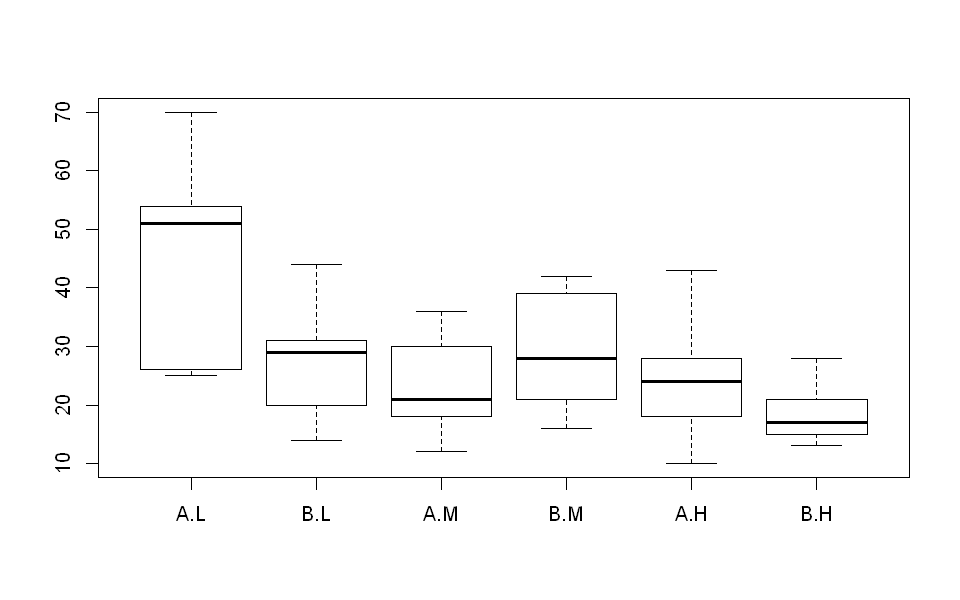

In [3]:
options(repr.plot.width=8, repr.plot.height=5)

boxplot(breaks ~ wool + tension, data=warpbreaks)

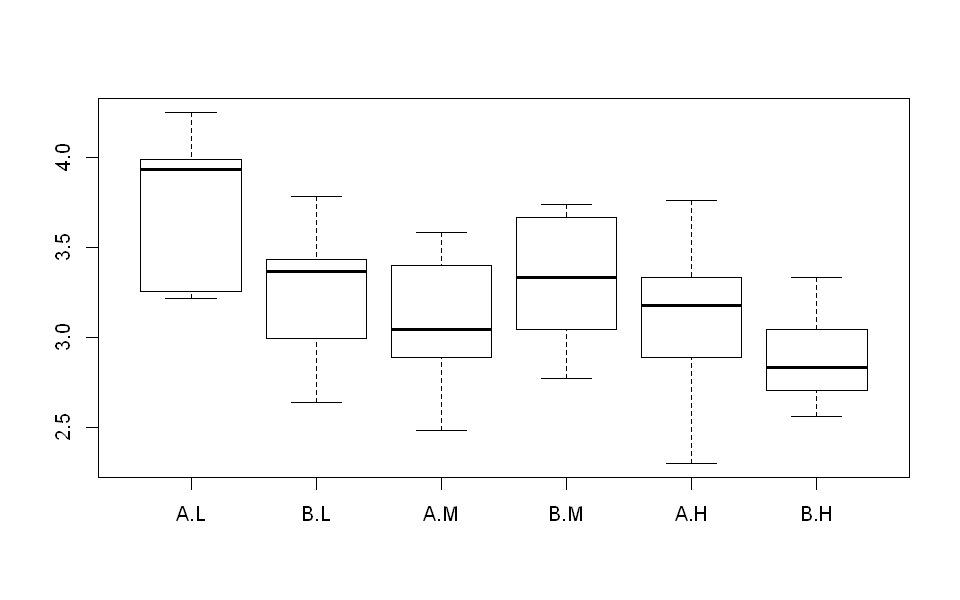

In [4]:
boxplot(log(breaks) ~ wool + tension, data=warpbreaks)

# The different groups have more similar variance if we use the logarithm of breaks. 
# From this visualization, it looks like both factors may play a role in the number of breaks. 
# It appears that there is a general decrease in breaks as we move from low to medium to high tension.

# One-way model

In [5]:
library("coda")
library("rjags")

Warning message:
"package 'coda' was built under R version 3.4.4"Warning message:
"package 'rjags' was built under R version 3.4.4"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [6]:
set.seed(83)

### Modelling

In [7]:
mod_1_str = " model {
    # Actual Bayesian Model
    for(i in 1:length(y)){
        y[i] ~ dnorm(mu[tensGrp[i]], prec)
    }

    # Priors
    for (j in 1:3){
        mu[j] ~ dnorm(0.0, 1.0/1.0e6)
    }
    prec ~ dgamma(5/2.0, 5*1.0/2.0)

    # Variable dependent on Priors
    sig = sqrt(1/prec)
} "

In [8]:
data_1_jags = list(y = log(warpbreaks$breaks), tensGrp = as.numeric(warpbreaks$tension))

In [9]:
params_1 = c("mu", "sig")

In [10]:
inits_1 = function(){
    inits = list(mu = rnorm(3, 1.0, 100.0), 
                 prec = rgamma(1, 1.0, 1.0))
}

In [11]:
mod1 = jags.model(textConnection(mod_1_str), 
                  inits = inits_1, 
                  data = data_1_jags, 
                  n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 54
   Unobserved stochastic nodes: 4
   Total graph size: 122

Initializing model



### Simulations

In [12]:
update(mod1, 1e3)

In [13]:
mod_1_sim = coda.samples(model = mod1, 
                         variable.names = params_1, 
                         n.iter = 1e4)

In [14]:
mod_1_csim = as.mcmc(do.call(rbind, mod_1_sim))

### Model Checking

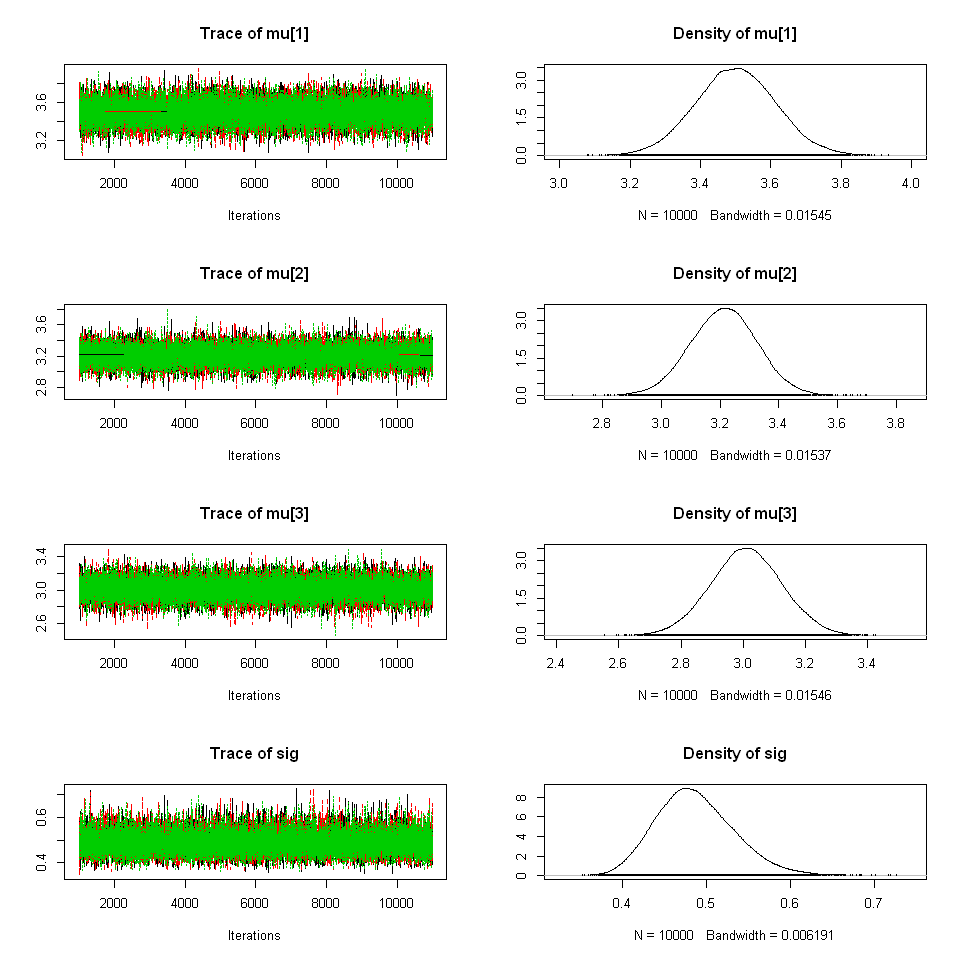

In [15]:
options(repr.plot.width=8, repr.plot.height=8)

plot(mod_1_sim)

In [16]:
gelman.diag(mod_1_sim)
autocorr.diag(mod_1_sim)
effectiveSize(mod_1_sim)

Potential scale reduction factors:

      Point est. Upper C.I.
mu[1]          1          1
mu[2]          1          1
mu[3]          1          1
sig            1          1

Multivariate psrf

1

,mu[1],mu[2],mu[3],sig
Lag 0,1.0000000000,1.000000000,1.0000000000,1.000000000
Lag 1,0.0010854604,-0.002000921,-0.0022761575,0.047455575
Lag 5,0.0081608128,0.001692462,0.0006040648,0.009644711
Lag 10,-0.0001133468,0.001783390,0.0050357903,0.004160427
Lag 50,0.0039137063,-0.004286038,-0.0027895087,0.004127304


mu[1]    mu[2]    mu[3]      sig 
29851.51 29978.78 30000.00 28187.12

### Results

In [17]:
summary(mod_1_sim)

# The 95% posterior interval for the mean of group 2 (medium tension) overlaps with both the low and high groups,
# but the intervals for low and high group only slightly overlap. That is a pretty strong indication that the means
# for low and high tension are different.


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
mu[1] 3.5000 0.11504 0.0006642      0.0006660
mu[2] 3.2129 0.11480 0.0006628      0.0006634
mu[3] 3.0106 0.11572 0.0006681      0.0006681
sig   0.4874 0.04677 0.0002700      0.0002787

2. Quantiles for each variable:

        2.5%    25%    50%    75%  97.5%
mu[1] 3.2749 3.4234 3.5001 3.5769 3.7294
mu[2] 2.9876 3.1365 3.2138 3.2892 3.4378
mu[3] 2.7832 2.9340 3.0107 3.0876 3.2378
sig   0.4059 0.4548 0.4838 0.5163 0.5887


In [18]:
dic_1 = dic.samples(mod1, 1e4)
dic_1

Mean deviance:  58.43 
penalty 4.058 
Penalized deviance: 62.49 

# Two-way Additive Model

We will fit the additive model which treats the two factors separately with no interaction.

In [19]:
# Design Matrix

X = model.matrix(breaks ~ wool + tension, data=warpbreaks)
head(X)

(Intercept),woolB,tensionM,tensionH
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0
1,0,0,0


In [20]:
# By default, R has chosen the mean for wool A and low tension to be the intercept. 
# Then, there is an effect for wool B, and effects for medium tension and high tension, 
# each associated with dummy indicator variables.

### Modelling

In [21]:
mod_2_str = " model {
    # Actual Bayesian Model
    for(i in 1:length(y)){
        y[i] ~ dnorm(mu[i], prec)
        mu[i] = int + alpha*isWoolB[i] + beta[1]*isTensionM[i] + beta[2]*isTensionH[i]
    }

    # Priors
    for (j in 1:2){
        beta[j] ~ dnorm(0.0, 1.0/1.0e6)
    }
    int ~ dnorm(0.0, 1.0/1.0e6)
    alpha ~ dnorm(0.0, 1.0/1.0e6)
    prec ~ dgamma(3/2.0, 3*1.0/2.0)

    # Variable dependent on Priors
    sig = sqrt(1/prec)
} "

In [22]:
data_2_jags = list(y = log(warpbreaks$breaks), 
                   isWoolB = X[,"woolB"], 
                   isTensionM = X[,"tensionM"], 
                   isTensionH = X[,"tensionH"])

In [23]:
params_2 = c("int", "alpha", "beta", "sig")

In [24]:
inits_2 = function(){
    inits = list(int = rnorm(1, 1.0, 100.0), 
                 alpha = rnorm(1, 1.0, 100.0), 
                 beta = rnorm(2, 1.0, 100.0),
                 prec = rgamma(1, 1.0, 1.0))
}

In [25]:
mod2 = jags.model(textConnection(mod_2_str), 
                  inits = inits_2, 
                  data = data_2_jags, 
                  n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 54
   Unobserved stochastic nodes: 5
   Total graph size: 243

Initializing model



### Simulations

In [26]:
update(mod2, 1e3)

In [27]:
mod_2_sim = coda.samples(model = mod2, 
                         variable.names = params_2, 
                         n.iter = 1e4)

In [28]:
mod_2_csim = as.mcmc(do.call(rbind, mod_2_sim))

### Model Checking

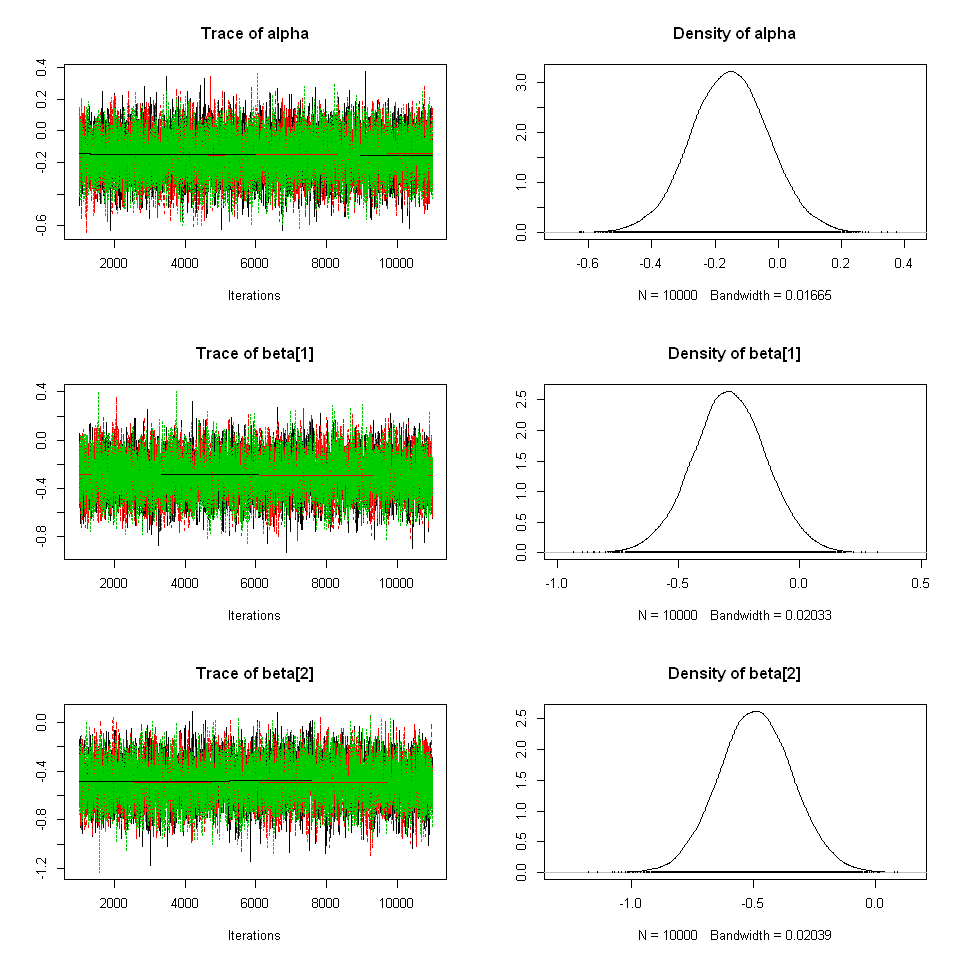

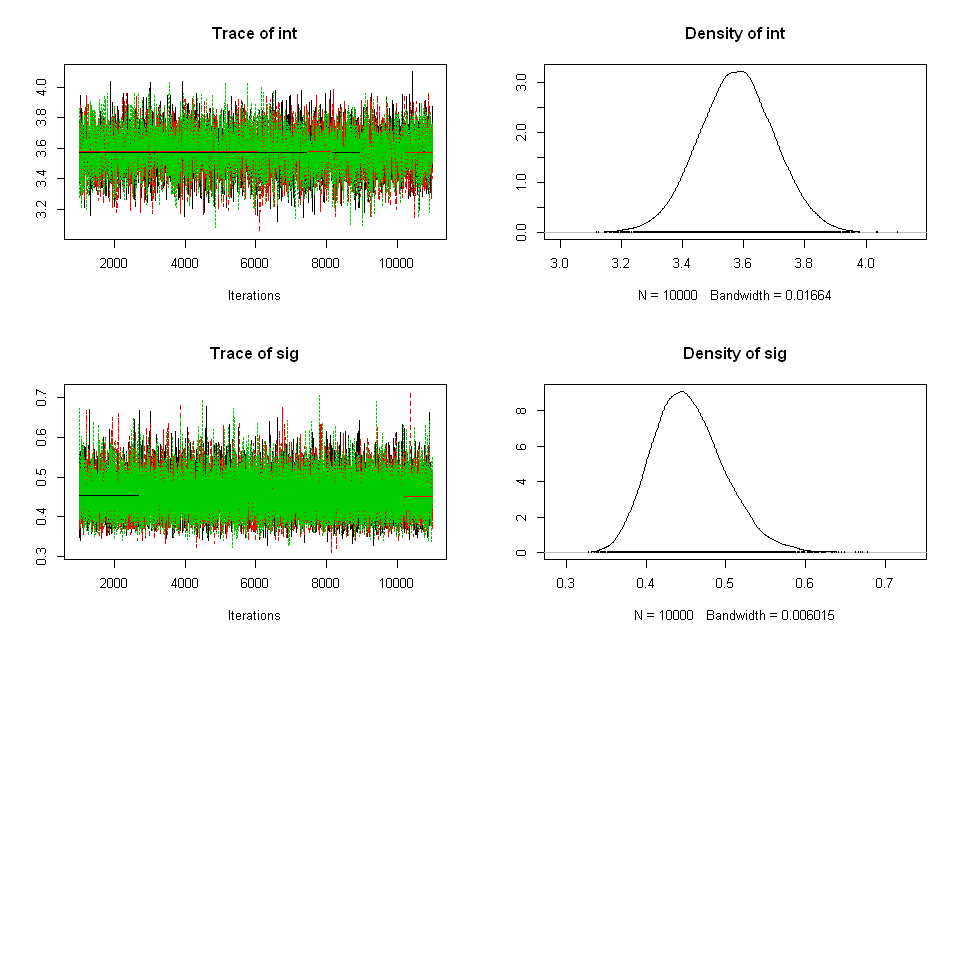

In [29]:
plot(mod_2_sim)

In [30]:
gelman.diag(mod_2_sim)
autocorr.diag(mod_2_sim)
effectiveSize(mod_2_sim)

Potential scale reduction factors:

        Point est. Upper C.I.
alpha            1          1
beta[1]          1          1
beta[2]          1          1
int              1          1
sig              1          1

Multivariate psrf

1

,alpha,beta[1],beta[2],int,sig
Lag 0,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000
Lag 1,0.494324623,0.497486633,0.491601913,0.750779961,0.070690017
Lag 5,0.026251730,0.092469892,0.095059980,0.176218110,0.004976091
Lag 10,-0.008834270,0.009651229,0.018315548,0.018208832,0.001821280
Lag 50,-0.005129736,0.006051210,0.002696888,0.002170663,-0.001604680


alpha   beta[1]   beta[2]       int       sig 
10698.518  7645.360  7783.415  4961.209 24323.411

### Results

In [31]:
summary(mod_2_sim)


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean      SD  Naive SE Time-series SE
alpha   -0.1527 0.12376 0.0007145      0.0011992
beta[1] -0.2884 0.15244 0.0008801      0.0017449
beta[2] -0.4897 0.15172 0.0008760      0.0017196
int      3.5771 0.12442 0.0007183      0.0017664
sig      0.4540 0.04524 0.0002612      0.0002915

2. Quantiles for each variable:

           2.5%     25%     50%      75%    97.5%
alpha   -0.3990 -0.2357 -0.1525 -0.07023  0.09091
beta[1] -0.5911 -0.3888 -0.2887 -0.18683  0.01166
beta[2] -0.7846 -0.5907 -0.4904 -0.38807 -0.18963
int      3.3312  3.4949  3.5776  3.66020  3.82101
sig      0.3757  0.4222  0.4502  0.48201  0.55180


In [32]:
dic_2 = dic.samples(mod2, 1e4)
dic_2

Mean deviance:  55.5 
penalty 5.118 
Penalized deviance: 60.62 

In [33]:
# Comapre it with DIC of model 1

dic_1

Mean deviance:  58.43 
penalty 4.058 
Penalized deviance: 62.49 

In [34]:
# This suggests there is much to be gained adding the wool factor to the model. 
# Before we settle on this model however, we should consider whether there is an interaction. 
# Let’s look again at the box plot with all six treatment groups

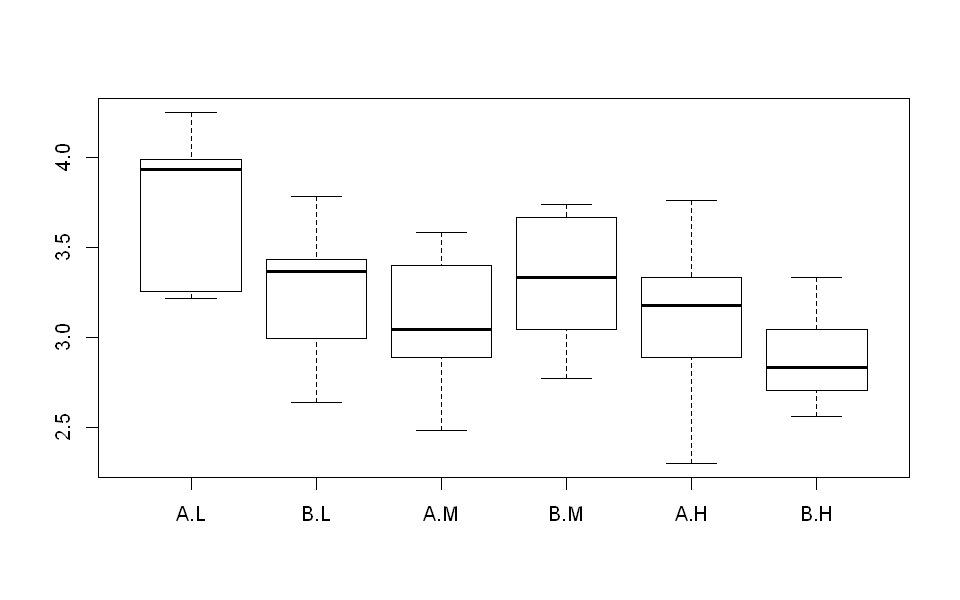

In [35]:
options(repr.plot.width=8, repr.plot.height=5)

boxplot(log(breaks) ~ wool + tension, data=warpbreaks)

In [36]:
# This two-way model has a single effect for wool B and the estimate is negative. 
# If this is true, then we would expect wool B to be associated with fewer breaks than its wool A counterpart on average.
# This is true for low and high tension, but it appears that breaks are higher for wool B when there is medium tension.
# That is, the effect for wool B is not consistent across tension levels, so it may appropriate to add an interaction term.

In [37]:
# Similar Model can be created in R.

lmod2 = lm(log(breaks) ~ .^2, data=warpbreaks)
summary(lmod2)


Call:
lm(formula = log(breaks) ~ .^2, data = warpbreaks)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.81504 -0.27885  0.04042  0.27319  0.64358 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.7179     0.1247  29.824  < 2e-16 ***
woolB           -0.4356     0.1763  -2.471  0.01709 *  
tensionM        -0.6012     0.1763  -3.410  0.00133 ** 
tensionH        -0.6003     0.1763  -3.405  0.00134 ** 
woolB:tensionM   0.6281     0.2493   2.519  0.01514 *  
woolB:tensionH   0.2221     0.2493   0.891  0.37749    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.374 on 48 degrees of freedom
Multiple R-squared:  0.3363,	Adjusted R-squared:  0.2672 
F-statistic: 4.864 on 5 and 48 DF,  p-value: 0.001116


In [38]:
# Adding the interaction, we get an effect for being in wool B and medium tension, as well as for being in wool B 
# and high tension. There are now six parameters for the mean, one for each treatment group, so this model is 
# equivalent to the full cell means model.

# Two-way cell means model

In this new model, μ will be a matrix with six entries, each corresponding to a treatment group.

In [39]:
mod_3_str = " model {
    # Actual Bayesian Model
    for(i in 1:length(y)){
        y[i] ~ dnorm(mu[woolGrp[i], tensGrp[i]], prec)
    }

    # Priors
    for (j in 1:max(woolGrp)){
        for (k in 1:max(tensGrp)){
            mu[j, k] ~ dnorm(0.0, 1.0/1.0e6)
    }}
    prec ~ dgamma(3/2.0, 3*1.0/2.0)

    # Variable dependent on Priors
    sig = sqrt(1/prec)
} "

In [40]:
data_3_jags = list(y = log(warpbreaks$breaks), 
                   woolGrp = as.numeric(warpbreaks$wool), 
                   tensGrp = as.numeric(warpbreaks$tension))

In [41]:
params_3 = c("mu", "sig")

In [42]:
inits_3 = function(){
    inits = list(mu = matrix(rnorm(6, 1.0, 100.0), nrow = 2, byrow = TRUE),
                 prec = rgamma(1, 1.0, 1.0))
}

In [43]:
mod3 = jags.model(textConnection(mod_3_str), 
                  inits = inits_3, 
                  data = data_3_jags, 
                  n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 54
   Unobserved stochastic nodes: 7
   Total graph size: 179

Initializing model



### Simulations

In [44]:
update(mod3, 1e3)

In [45]:
mod_3_sim = coda.samples(model = mod3, 
                         variable.names = params_3, 
                         n.iter = 1e4)

In [46]:
mod_3_csim = as.mcmc(do.call(rbind, mod_3_sim))

### Model Checking

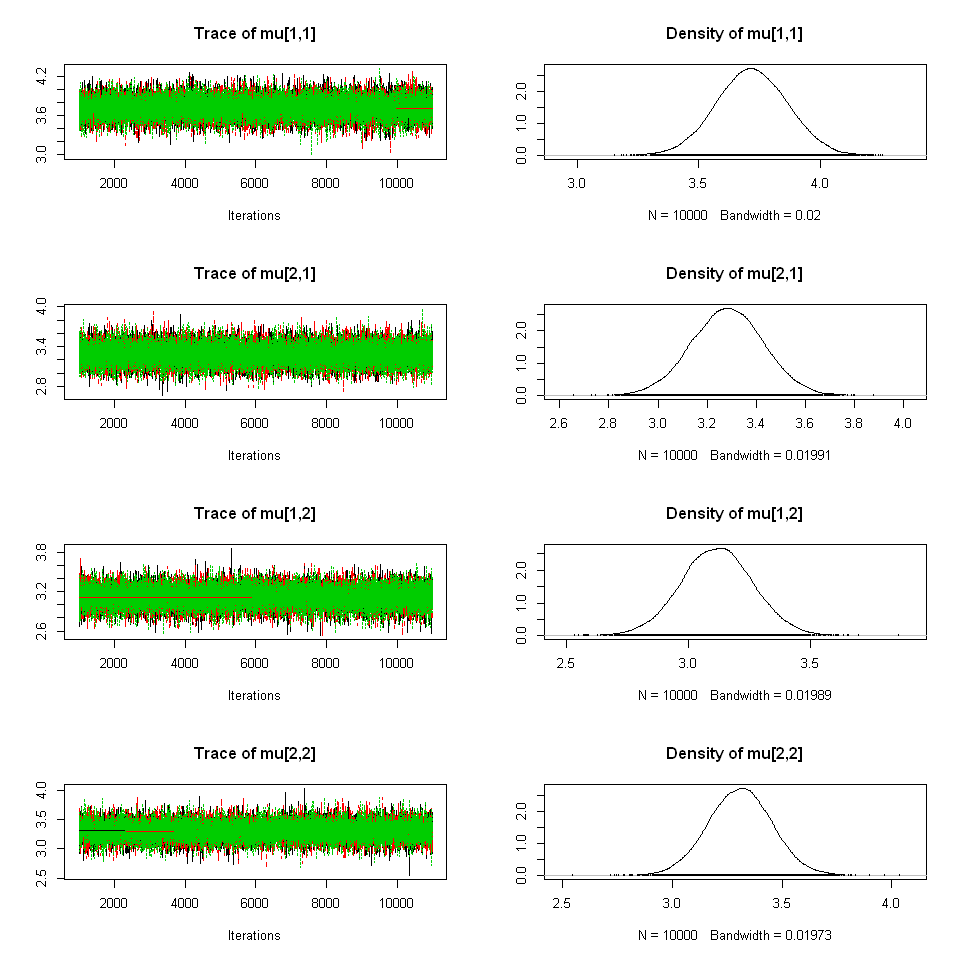

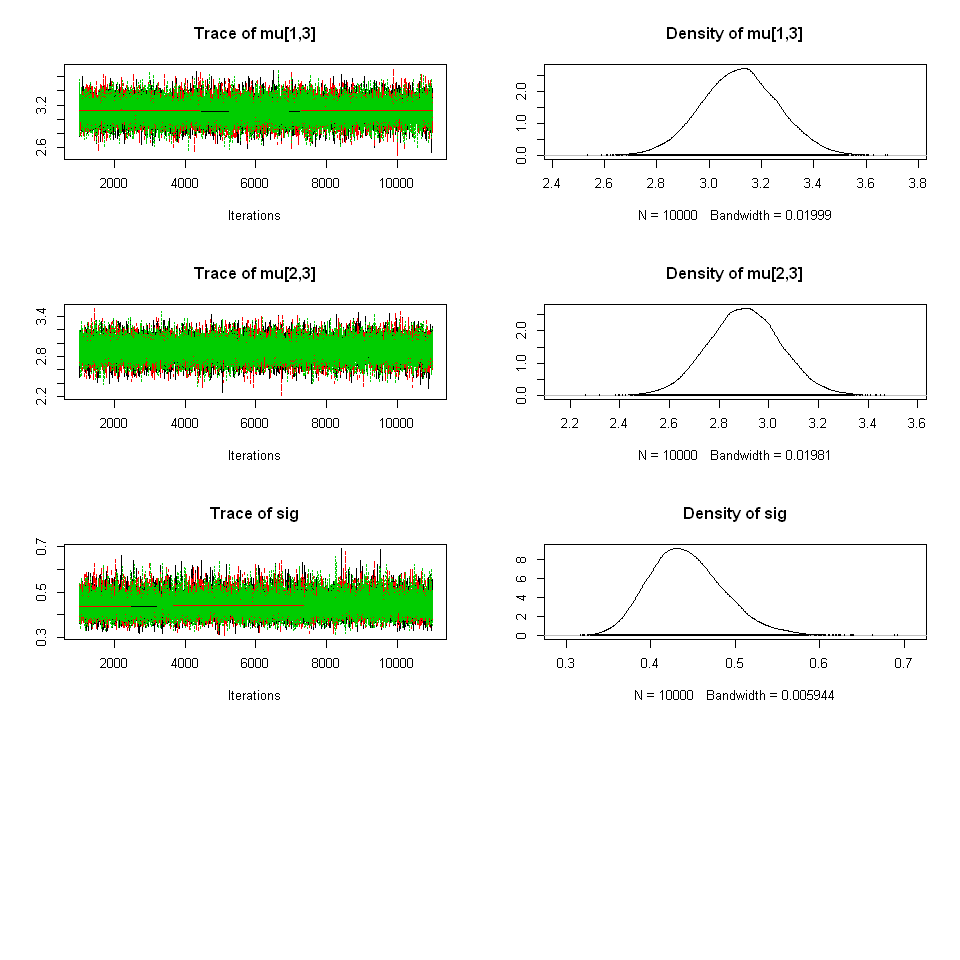

In [47]:
options(repr.plot.width=8, repr.plot.height=8)

plot(mod_3_sim)

In [48]:
gelman.diag(mod_3_sim)
autocorr.diag(mod_3_sim)
effectiveSize(mod_3_sim)
raftery.diag(mod_3_sim)

Potential scale reduction factors:

        Point est. Upper C.I.
mu[1,1]          1          1
mu[2,1]          1          1
mu[1,2]          1          1
mu[2,2]          1          1
mu[1,3]          1          1
mu[2,3]          1          1
sig              1          1

Multivariate psrf

1

,"mu[1,1]","mu[2,1]","mu[1,2]","mu[2,2]","mu[1,3]","mu[2,3]",sig
Lag 0,1.000000000,1.0000000000,1.000000000,1.000000000,1.000000000,1.0000000000,1.0000000000
Lag 1,0.002952882,-0.0027651394,0.009436619,-0.006414853,0.005386278,0.0014122397,0.1106946665
Lag 5,0.006347014,-0.0006813923,-0.012201273,-0.001916514,-0.001307367,-0.0002430568,0.0062535733
Lag 10,0.002281276,-0.0005362458,0.005720226,-0.006470848,-0.005533829,0.0072493272,0.0002376414
Lag 50,0.002611471,-0.0035347310,-0.005368418,0.003237628,-0.005397786,-0.0085805503,-0.0027393338


mu[1,1]  mu[2,1]  mu[1,2]  mu[2,2]  mu[1,3]  mu[2,3]      sig 
30000.00 30000.00 29452.89 30000.00 29691.98 29636.32 24024.79

[[1]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                               
         Burn-in  Total Lower bound  Dependence
         (M)      (N)   (Nmin)       factor (I)
 mu[1,1] 2        3835  3746         1.020     
 mu[2,1] 2        3771  3746         1.010     
 mu[1,2] 2        3802  3746         1.010     
 mu[2,2] 2        3680  3746         0.982     
 mu[1,3] 2        3680  3746         0.982     
 mu[2,3] 1        3726  3746         0.995     
 sig     2        3834  3746         1.020     


[[2]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                               
         Burn-in  Total Lower bound  Dependence
         (M)      (N)   (Nmin)       factor (I)
 mu[1,1] 2        3834  3746         1.020     
 mu[2,1] 2        3865  3746         1.030     
 mu[1,2] 2        3741  3746         0.999     
 mu[2,2] 2        3741  3746         0.999     
 mu[1,3] 2        3636  3746

### Results

In [49]:
summary(mod_3_sim)


Iterations = 1001:11000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean      SD  Naive SE Time-series SE
mu[1,1] 3.7193 0.14859 0.0008579      0.0008579
mu[2,1] 3.2833 0.14827 0.0008560      0.0008560
mu[1,2] 3.1166 0.14807 0.0008549      0.0008631
mu[2,2] 3.3089 0.14736 0.0008508      0.0008508
mu[1,3] 3.1177 0.14915 0.0008611      0.0008659
mu[2,3] 2.9026 0.14856 0.0008577      0.0008631
sig     0.4431 0.04495 0.0002595      0.0002902

2. Quantiles for each variable:

          2.5%    25%    50%    75% 97.5%
mu[1,1] 3.4293 3.6201 3.7186 3.8188 4.012
mu[2,1] 2.9902 3.1840 3.2838 3.3819 3.577
mu[1,2] 2.8237 3.0174 3.1169 3.2150 3.408
mu[2,2] 3.0196 3.2105 3.3094 3.4065 3.600
mu[1,3] 2.8251 3.0181 3.1175 3.2167 3.411
mu[2,3] 2.6117 2.8042 2.9026 3.0010 3.198
sig     0.3656 0.4116 0.4393 0.4707 0.542


In [50]:
dic_3 = dic.samples(model = mod3, n.iter = 1e4)
dic_3

Mean deviance:  52.02 
penalty 7.183 
Penalized deviance: 59.2 

In [51]:
# Compare with DIC of model1

dic_1

Mean deviance:  58.43 
penalty 4.058 
Penalized deviance: 62.49 

In [52]:
# Compare with DIC of model1

dic_2

Mean deviance:  55.5 
penalty 5.118 
Penalized deviance: 60.62 

In [53]:
# This suggests that the full model with interaction between wool and tension (which is equivalent to the cell
# means model) is the best for explaining/predicting warp breaks.

In [54]:
HPDinterval(mod_3_csim, prob = 0.95)

,lower,upper
"mu[1,1]",3.4380064,4.019679
"mu[2,1]",2.9850353,3.569711
"mu[1,2]",2.8208823,3.404403
"mu[2,2]",3.0121213,3.591430
"mu[1,3]",2.8264689,3.412145
"mu[2,3]",2.6106286,3.196600
sig,0.3573223,0.531180


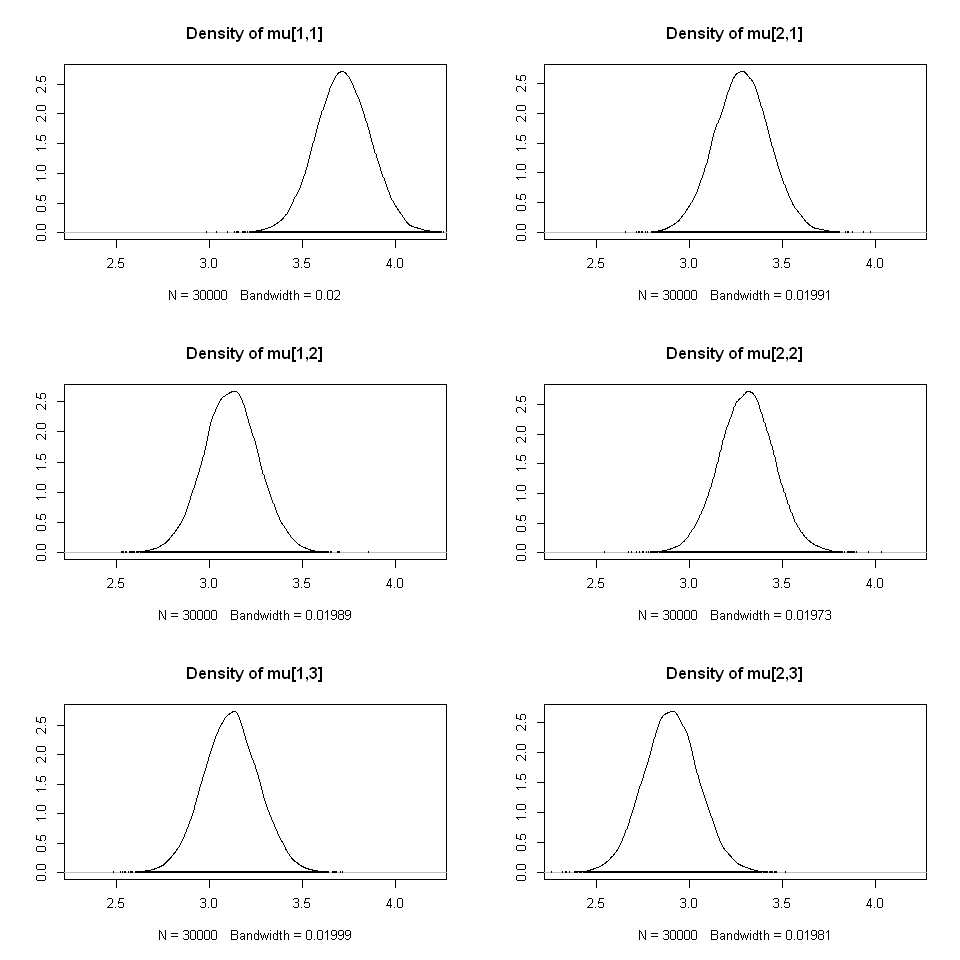

In [55]:
par(mfrow=c(3,2)) # arrange frame for plots
densplot(mod_3_csim[,1:6], xlim=c(2.3, 4.2))

It might be tempting to look at comparisons between each combination of treatments, but this could yield spurious results. It is best not to search your results for interesting hypotheses, because if there are many hypotheses, some will appear to show “effects” or “associations” simply due to chance. Results are most reliable when we determine a relatively small number of hypotheses we are interested in beforehand, collect the data, and statistically evaluate the evidence for them.

One question we might be interested in with these data is finding the treatment combination that produces the fewest breaks. To calculate this, we can go through our posterior samples and for each sample, find out which group has the smallest mean. These counts help us determine the posterior probability that each of the treatment groups has the smallest mean.

In [56]:
prop.table( table( apply(mod_3_csim[,1:6], 1, which.min) ) )


         2          3          4          5          6 
0.01560000 0.11643333 0.01043333 0.11386667 0.74366667 

In [57]:
# The evidence supports wool B with high tension as the treatment that produces the fewest breaks.